In [2]:
from src.DataFolder import DataFolder
from src.NeuralSignal import NeuralSignal
from src.runtime_logger import logger_setup

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_path = "/home/miranjo/phasic_tonic/data/processed"
config_path = "/home/miranjo/phasic_tonic/configs/test.yaml"

## Setup

### Load the config file

In [3]:
with open(config_path, 'r') as f:
    args = yaml.safe_load(f)

fs                  = args.pop("fs")
f_theta             = (args.pop("f_theta_lower"), args.pop("f_theta_upper"))
f_lowpass           = args.pop("f_lowpass")
lowpass_length      = args.pop("lowpass_length")
bandpass_length     = args.pop("bandpass_length")
threshold_bycycle   = args.pop("threshold_bycycle")
threshold_episode   = args.pop("threshold_episode")

# Start logger
logger_setup()

Runtime log started.
Logging to file runtime.log


### Load the dataset

In [4]:
remFolder = DataFolder(data_path)

Initializing a DataFolder.
DataFolder in /home/miranjo/phasic_tonic/data/processed contains 102 files.


# Segmenting REM sleep into phasic and tonic episodes.

## Direct approach

We use the cycle-by-cycle approach to identify phasic and tonic REM sleep substates in rodents.

### Load and preprocess the data

Text(0.5, 1.0, 'nasdas')

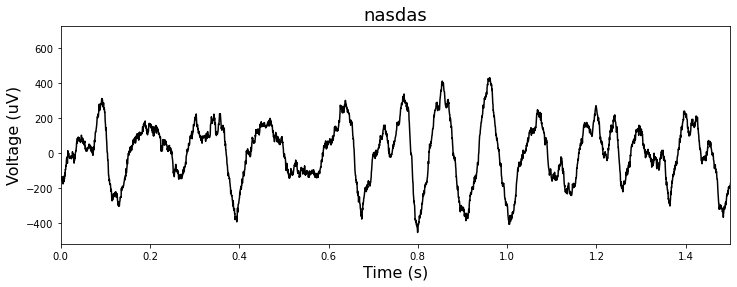

In [20]:
remData = remFolder[3]
arrays = remData["data"]

sig = arrays[0]

times = np.arange(0, len(sig)/fs, 1 / fs)
plt.figure(figsize=(12,4))
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.plot(times, sig, color='k', label='raw')
plt.xlim(0, 1.5)

(0.0, 5.0)

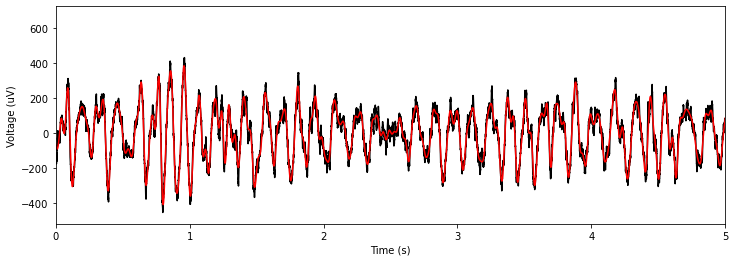

In [43]:
# Apply a Lowpass filter
from neurodsp.filt import filter_signal

sig_low = filter_signal(sig, fs, "lowpass", f_lowpass, n_seconds=lowpass_length, remove_edges=False)
plt.figure(figsize=(12,4))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.plot(times, sig, color='k', label='raw')
plt.plot(times, sig_low, color='r', label='lowpass')
plt.xlim(0, 5)

### Segmenting the signal into phasic and tonic episodes

In [44]:
from bycycle.features import compute_features

# Compute cycle-by-cycle features
df = compute_features(sig_low, fs, f_range=f_theta, threshold_kwargs=threshold_bycycle)

# Extract the timestamps and burst detection results
df = df[["sample_last_trough", "sample_next_trough", "is_burst"]]
phasic_df = df[df["is_burst"] == True]
tonic_df = df[df["is_burst"] == False]

In [45]:
def get_episodes(df_features, threshold_episode):
    l1 = df_features["sample_last_trough"].to_numpy()
    l2 = df_features["sample_next_trough"].to_numpy()

    # List to store extracted episodes
    episodes = []

    # Assign the start of the first episode
    start = l1[0]
    
    # Initialize the end of the first episode
    end = 0

    for i, l1_i in enumerate(l1):
        if (l1_i - l2[i - 1]) > threshold_episode:
            # Set the end of the current episode
            end = l2[i - 1]
            # Append the current episode to the list
            episodes.append((start, end))
            # Update the start for the next episode
            start = l1_i
    # Set the end of the last episode
    end = l2[-1]
    # Append the last episode to the list
    episodes.append((start, end))
    return episodes
 
threshold_episode = 2500 # If two cycles are within 2500 sampling points, i.e 1 second, then they are connected

# Connect the consecutive cycles to form an episode 
phasic = get_episodes(phasic_df, threshold_episode=threshold_episode)
tonic = get_episodes(tonic_df, threshold_episode=0)
phasic

[(106815, 109012), (171571, 174690)]

In [46]:
tonic

[(312, 106815), (109012, 171571), (174690, 305456)]

## NeuralSignal approach

We can process the previous steps in an object oriented way.

Initializing NeuralSignal.


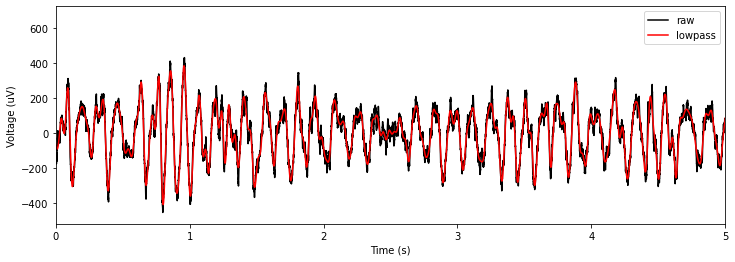

In [49]:
remData = remFolder[3]
arrays = remData["data"]
metadata = remData["metadata"]

theta = NeuralSignal(arrays[0], fs)
theta.filter("lowpass", f_range=f_lowpass, n_seconds=lowpass_length)
theta.plot(xlim=(0,5), figsize=(12,4))

Run the cycle-by-cycle algorithm. We then segment the signal into phasic and tonic episodes.

In [50]:
theta.segment(f_range=f_theta, threshold_episode=threshold_episode, threshold_bycycle=threshold_bycycle)
theta.phasic

STARTED: Segmenting the signal into phasic and tonic episodes.
Found 19 phasic cycles in the signal
Found 894 tonic cycles in the signal
COMPLETED: Segmenting the signal into phasic and tonic episodes.


[(106815, 109012), (171571, 174690)]

# Visualizing the data

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

signal = sig_low
t = np.arange(len(signal))/fs
fig = go.Figure(data=go.Scatter(x=t, y=signal, mode='lines', line=dict(color="black")))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title="Rat3 LFP", xaxis_title="Time", yaxis_title="Voltage (uV)")

f = go.FigureWidget(fig)
f